# Diagnosing Diabetes with Classification Models

The data set has 8 predictors:

1. **Pregnancies:** the number of pregnancies each patient has endured.

2. **Glucose:** the fasting blood sugar of each patient, measured in milligrams per decileter (mg/dL).

3.  **BloodPressure:** the diastolic blood pressure ("bottom number") measured in millimeters of Mercury (mmHg).

4. **SkinThickness:** the triceps skin fold thickness measured in millimeters (mm).

5. **Insulin:** the 2 hour serum insulin test result. It tests the amount of insulin left in the patient's bloodstream after an oral intake of glucose, measured in the standard insulin concentration unit $\mu U$/mL.

6. **BMI:** the Body Mass Index of each patient, using the following formula:
$$\text{BMI} = \frac{\text{weight of patient (in kg)}}{\text{squared height of patient (in $m^2$)}}.$$

7. **DiabetesPedigreeFunction:** the measure of likelihood that a patient gets diagnosed with diabetes in their lifetime based on their family history.

8. **Age:** the age of each patient in years.

The response is **Outcome,** which is the indicator of whether a patient has been diagnosed with diabetes. If the patient has been diagnosed, the outcome is $1;$ otherwise, the outcome is $0.$

## Import All Libraries

In [223]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.graphics.gofplots import ProbPlot
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV
from sklearn.preprocessing import scale
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

## Read in Diabetes Data

In [173]:
df = pd.read_csv("../Data Science Projects/diabetes.csv")

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Outcome Distribution

Below is a histogram of the distribution of outcomes; that is, we are comparing the number of patients who have been diagnosed with diabetes and the number of patients that have not been diagnosed with diabetes. In this data set:

1. 34.896% of the patients have been diagnosed with diabetes.

2. The remaining 65.104% of the patients have not been diagnosed with diabetes.

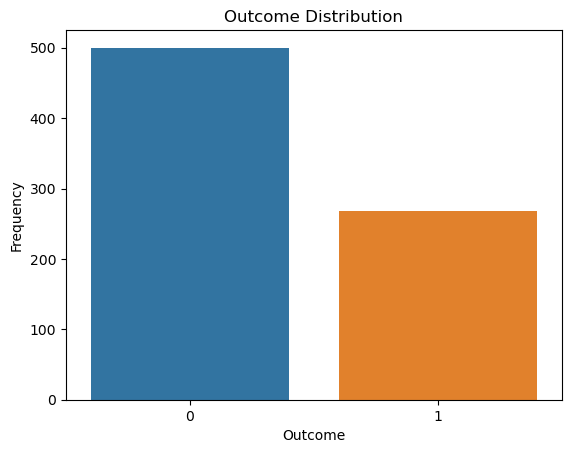

In [174]:
sns.countplot(data=df, x=df['Outcome']).set(title='Outcome Distribution', ylabel='Frequency')
plt.show()

In [175]:
print(f"{round((df[df['Outcome'] == 1].shape[0]/df.shape[0])*100, 3)}% of the patients have been diagnosed with diabetes.")
print(f"{round((df[df['Outcome'] == 0].shape[0]/df.shape[0])*100, 3)}% of the patients have not been diagnosed with diabetes.")

34.896% of the patients have been diagnosed with diabetes.
65.104% of the patients have not been diagnosed with diabetes.


## Checking for Potential Outliers

Below is a box-and-whisker plot for each predictor of the data set. The potential outliers are investigated below.

<Axes: >

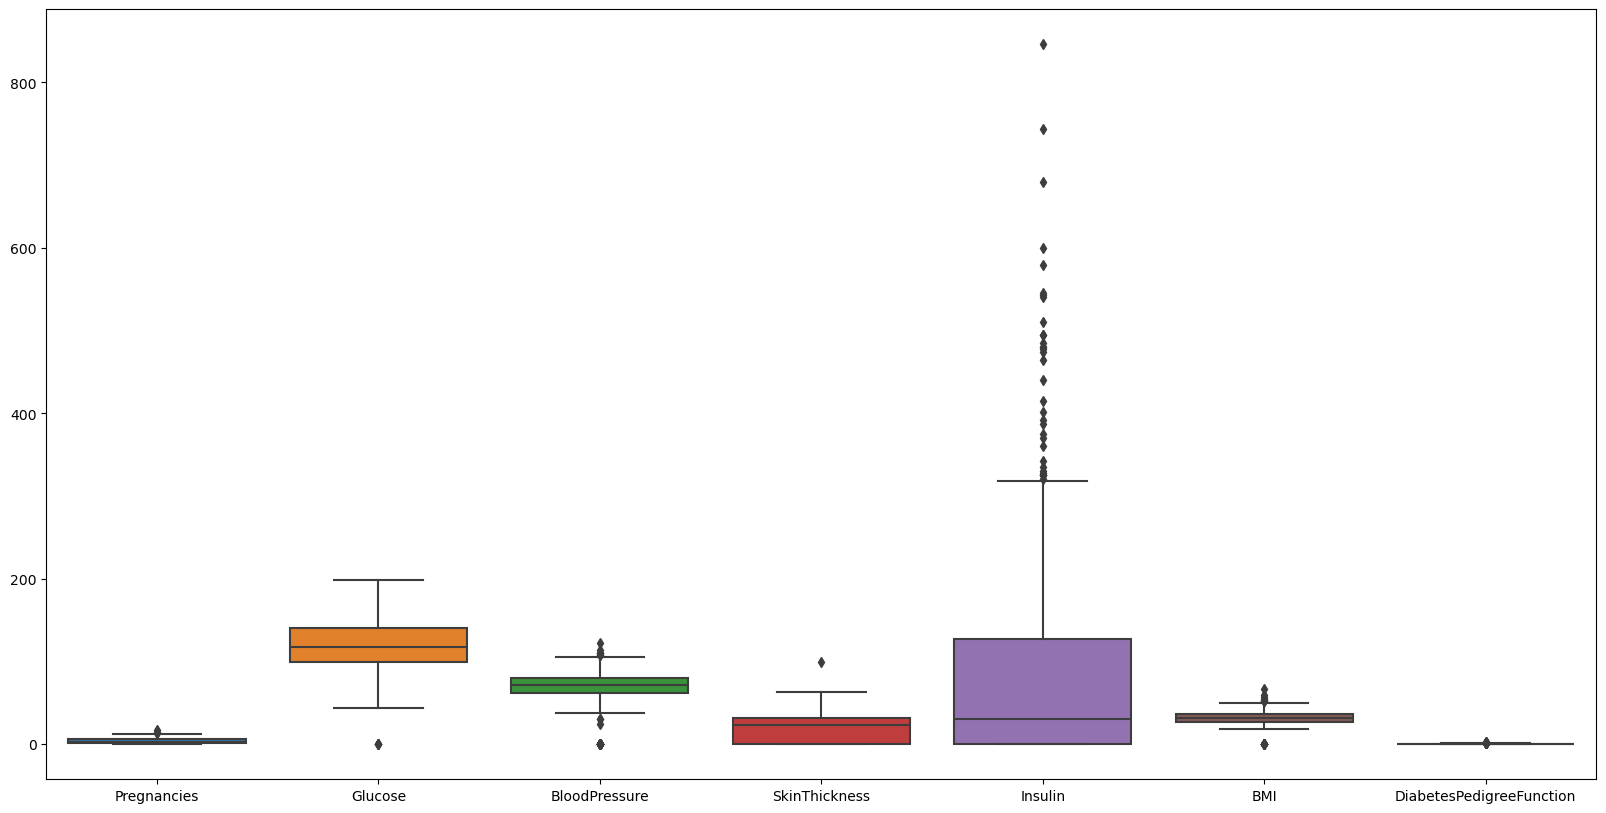

In [176]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(data=df.iloc[:,:7], ax=ax)

## Analysis of Outliers/Missing Data



### Glucose Outliers

According to the box-and-whisker plot, the only potential outliers in the Glucose column are the data points where Glucose is zero. A glucose value of zero is not a possible value for a living patient, and hence this is simply missing data. Since this accounts for only 0.65% of the data, we can impute these values by multiple linear regression.

In [177]:
df[df['Glucose'] == 0]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
75,1,0,48,20,0,24.7,0.140,22,0
182,1,0,74,20,23,27.7,0.299,21,0
342,1,0,68,35,0,32.0,0.389,22,0
349,5,0,80,32,0,41.0,0.346,37,1
502,6,0,68,41,0,39.0,0.727,41,1


In [178]:
print(f"The Glucose outliers account for {round((df[df['Glucose'] == 0].shape[0]*100)/(df.shape[0]), 3)}% of the data.")

The Glucose outliers account for 0.651% of the data.


### BloodPressure Outliers

The box-and-whisker plot indicates that the possible outliers of the BloodPressure column are values such that the value is less than approximately 40, and values that are greater than approximately 100. According to John David, M.D., a Board-Certified Internal Medicine Physician of 20 years, the nonzero values of BloodPressure are not unrealistic numbers, they are just indicators of hypotension and hypertension for the exceptionally low and high BloodPressure values, respectively. The zero BloodPressure values are highly unrealistic, however.

In [179]:
df.loc[(df['BloodPressure'] < 40) | (df['BloodPressure'] > 100)]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
7,10,115,0,0,0,35.3,0.134,29,0
15,7,100,0,0,0,30.0,0.484,32,1
18,1,103,30,38,83,43.3,0.183,33,0
43,9,171,110,24,240,45.4,0.721,54,1
49,7,105,0,0,0,0.0,0.305,24,0
60,2,84,0,0,0,0.0,0.304,21,0
78,0,131,0,0,0,43.2,0.270,26,1
81,2,74,0,0,0,0.0,0.102,22,0
84,5,137,108,0,0,48.8,0.227,37,1
106,1,96,122,0,0,22.4,0.207,27,0


In [180]:
print(f"The BloodPressure outliers account for {round((df[(df['BloodPressure'] < 40) | (df['BloodPressure'] > 100)].shape[0]*100)/(df.shape[0]), 3)}% of the data.")

The BloodPressure outliers account for 6.771% of the data.


85.714% of patients with zero values for BloodPressure, SkinThickness, Insulin, and BMI simultaneously have not been diagnosed with diabetes. Due to this trend, we will keep these zero values because it appears that four or more missing predictors is associated with no diabetes diagnosis.

In [181]:
df.loc[(df['BloodPressure'] == 0) & (df['SkinThickness'] == 0) & (df['Insulin'] == 0) & (df['BMI'] == 0) & (df['Outcome'] == 0)].shape[0]/df.loc[(df['BloodPressure'] == 0) & (df['SkinThickness'] == 0) & (df['Insulin'] == 0) & (df['BMI'] == 0)].shape[0]

0.8571428571428571

### SkinThickness Outliers

The box-and-whisker plot indicates that the patient with a SkinThickness value of 99 is a potential outlier. This value is about 33% larger than the maximum SkinThickness in the box-and-whisker plot's range of reasonable values. Also, only one patient out of 758 patients has this large of a SkinThickness value. Due to such a rarity, it could potentially be a misread from the person who performed the triceps skin fold test. Thus, I will toss this outlier out.

In [182]:
df.loc[(df['SkinThickness'] > 50) | (df['SkinThickness'] == 0)]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
2,8,183,64,0,0,23.3,0.672,32,1
5,5,116,74,0,0,25.6,0.201,30,0
7,10,115,0,0,0,35.3,0.134,29,0
9,8,125,96,0,0,0.0,0.232,54,1
10,4,110,92,0,0,37.6,0.191,30,0
...,...,...,...,...,...,...,...,...,...
757,0,123,72,0,0,36.3,0.258,52,1
758,1,106,76,0,0,37.5,0.197,26,0
759,6,190,92,0,0,35.5,0.278,66,1
762,9,89,62,0,0,22.5,0.142,33,0


The distribution of Outcome among the SkinThickness being 0 is approximately the same as the entire dataset. Since this takes up a lot of the data, we will keep these data points for now and explore the SkinThickness' correlation with other predictors later.

In [183]:
df.loc[(df['SkinThickness'] == 0) & (df['Outcome'] == 1)].shape[0]/df.loc[(df['SkinThickness'] == 0)].shape[0]

0.3876651982378855

In [184]:
df = df.drop(index=df.loc[df['SkinThickness'] == 99].index).reset_index(drop=True)  # drop the SkinThickness outlier
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
762,10,101,76,48,180,32.9,0.171,63,0
763,2,122,70,27,0,36.8,0.340,27,0
764,5,121,72,23,112,26.2,0.245,30,0
765,1,126,60,0,0,30.1,0.349,47,1


### Insulin Outliers

The values of Insulin that are above 300 are potential outliers according to the box-and-whisker plot. But this is likely just an indicator of insulin resistance, which is a characteristic of Type 2 Diabetes.

We also do not need to look at the Insulin values of 0 since that is a characteristic of Type 1 Diabetes.

In [185]:
df[df['Insulin'] > 300]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
8,2,197,70,45,543,30.5,0.158,53,1
13,1,189,60,23,846,30.1,0.398,59,1
54,7,150,66,42,342,34.7,0.718,42,0
56,7,187,68,39,304,37.7,0.254,41,1
111,8,155,62,26,495,34.0,0.543,46,1
139,5,105,72,29,325,36.9,0.159,28,0
153,1,153,82,42,485,40.6,0.687,23,0
186,8,181,68,36,495,30.1,0.615,60,1
199,4,148,60,27,318,30.9,0.150,29,1
220,0,177,60,29,478,34.6,1.072,21,1


### BMI Outliers

It is impossible to have a BMI of 0. But, as noted in the *BloodPressure Outliers* section, 85.714% of patients with zero values for BloodPressure, SkinThickness, Insulin, and BMI simultaneously have not been diagnosed with diabetes. Due to this trend, we will keep these zero values.

In [186]:
df.loc[(df['BMI'] > 50) | (df['BMI'] == 0)]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
9,8,125,96,0,0,0.0,0.232,54,1
49,7,105,0,0,0,0.0,0.305,24,0
60,2,84,0,0,0,0.0,0.304,21,0
81,2,74,0,0,0,0.0,0.102,22,0
120,0,162,76,56,100,53.2,0.759,25,1
125,1,88,30,42,99,55.0,0.496,26,1
145,0,102,75,23,0,0.0,0.572,21,0
177,0,129,110,46,130,67.1,0.319,26,1
193,11,135,0,0,0,52.3,0.578,40,1
247,0,165,90,33,680,52.3,0.427,23,0


In [187]:
print(f"The BMI outliers account for {round((df[(df['BMI'] > 50) | (df['BMI'] == 0)].shape[0]/df.shape[0])*100, 3)}% of the data.")

The BMI outliers account for 2.477% of the data.


### Correlations Between Predictors

- SkinThickness has a moderate correlation with both Insulin and BMI. And so we can toss out the SkinThickness column.

- Pregnancies and age also have a rather strong positive correlation. To prevent multicollinearity issues, we will toss out the Pregnancies column since Age is more highly correlated with outcome.



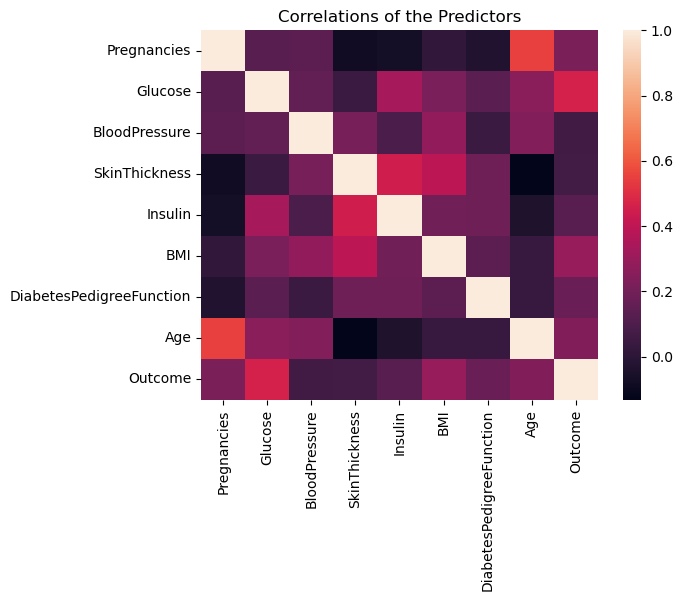

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.131674,0.141343,-0.079436,-0.074067,0.017933,-0.033309,0.548341,0.223189
Glucose,0.131674,1.000000,0.153013,0.042882,0.334854,0.220839,0.136886,0.257875,0.464625
BloodPressure,0.141343,0.153013,1.000000,0.210424,0.089003,0.281807,0.041249,0.240321,0.065065
SkinThickness,-0.079436,0.042882,0.210424,1.000000,0.448507,0.396713,0.184884,-0.132288,0.067136
Insulin,-0.074067,0.334854,0.089003,0.448507,1.000000,0.198247,0.185422,-0.040122,0.131984
BMI,0.017933,0.220839,0.281807,0.396713,0.198247,1.000000,0.140527,0.035286,0.292461
DiabetesPedigreeFunction,-0.033309,0.136886,0.041249,0.184884,0.185422,0.140527,1.000000,0.032698,0.173512
Age,0.548341,0.257875,0.240321,-0.132288,-0.040122,0.035286,0.032698,1.000000,0.235203
Outcome,0.223189,0.464625,0.065065,0.067136,0.131984,0.292461,0.173512,0.235203,1.000000


In [188]:
ax = plt.axes()
sns.heatmap(df.corr(), ax=ax, xticklabels=df.corr().columns, yticklabels=df.corr().columns)

ax.set_title('Correlations of the Predictors')
plt.show()

df.corr()

In [189]:
df.drop(columns=["SkinThickness", "Pregnancies"], inplace=True)

## Missing Data

Below is the percentage of data that each predictor's missing data accounts for. A rule of thumb is that for each predictor, if 5% or less of its data is missing, it is appropriate to impute the missing values. Otherwise, it is best to use a binary or categorical variable that indicates the data is missing. Below is the percentage of data that is missing for each predictor:

- **Glucose:** 0.65% of its data is missing.

- **BloodPressure:** 4.56% of its data is missing.

- **BMI:** 1.43% of its data is missing.

Hence, as established in the previous section, all predictors above with missing data are appropriate candidates for imputation.

In [190]:
for col in df.columns.tolist():
    if col not in ['Outcome', 'Insulin'] and df[df[col] == 0].shape[0] != 0:
        print(f'{col} has {df[df[col] == 0].shape[0]} missing values, accounting for {round((df[df[col] == 0].shape[0]/df.shape[0])*100, 2)}% of the data.')
        

Glucose has 5 missing values, accounting for 0.65% of the data.
BloodPressure has 35 missing values, accounting for 4.56% of the data.
BMI has 11 missing values, accounting for 1.43% of the data.


## Imputation

I will use multiple linear regression to impute the missing values of the Glucose predictor because it is deemed one of the more accurate methods of imputation.

Before each regression model is built, I will address the four assumptions that must be held for linear regression:

1. **Linearity:** Each predictor must have a linear relationship with the response.

2. **Normality:** The residuals must follow an approximately normal distribution.

3. **Constant Variance:** The residuals must have a constant variance.

4. **Independence/Uncorrelated Errors:** There should be no clusters of residuals along the fitted values. 

In [191]:
# this returns the data points with no missing data
df_nonzero = df[df['Glucose'] != 0].reset_index(drop=True)

df_nonzero

,Glucose,BloodPressure,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,148,72,0,33.6,0.627,50,1
1,85,66,0,26.6,0.351,31,0
2,183,64,0,23.3,0.672,32,1
3,89,66,94,28.1,0.167,21,0
4,137,40,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...
757,101,76,180,32.9,0.171,63,0
758,122,70,0,36.8,0.340,27,0
759,121,72,112,26.2,0.245,30,0
760,126,60,0,30.1,0.349,47,1


### Linear Regression Imputation for Missing Glucose Values

#### Check for Linearity

After plotting each predictor against the glucose values, we see that the predictors follow an approximately linear trend with the glucose response variable and hence, the linearity assumption holds.


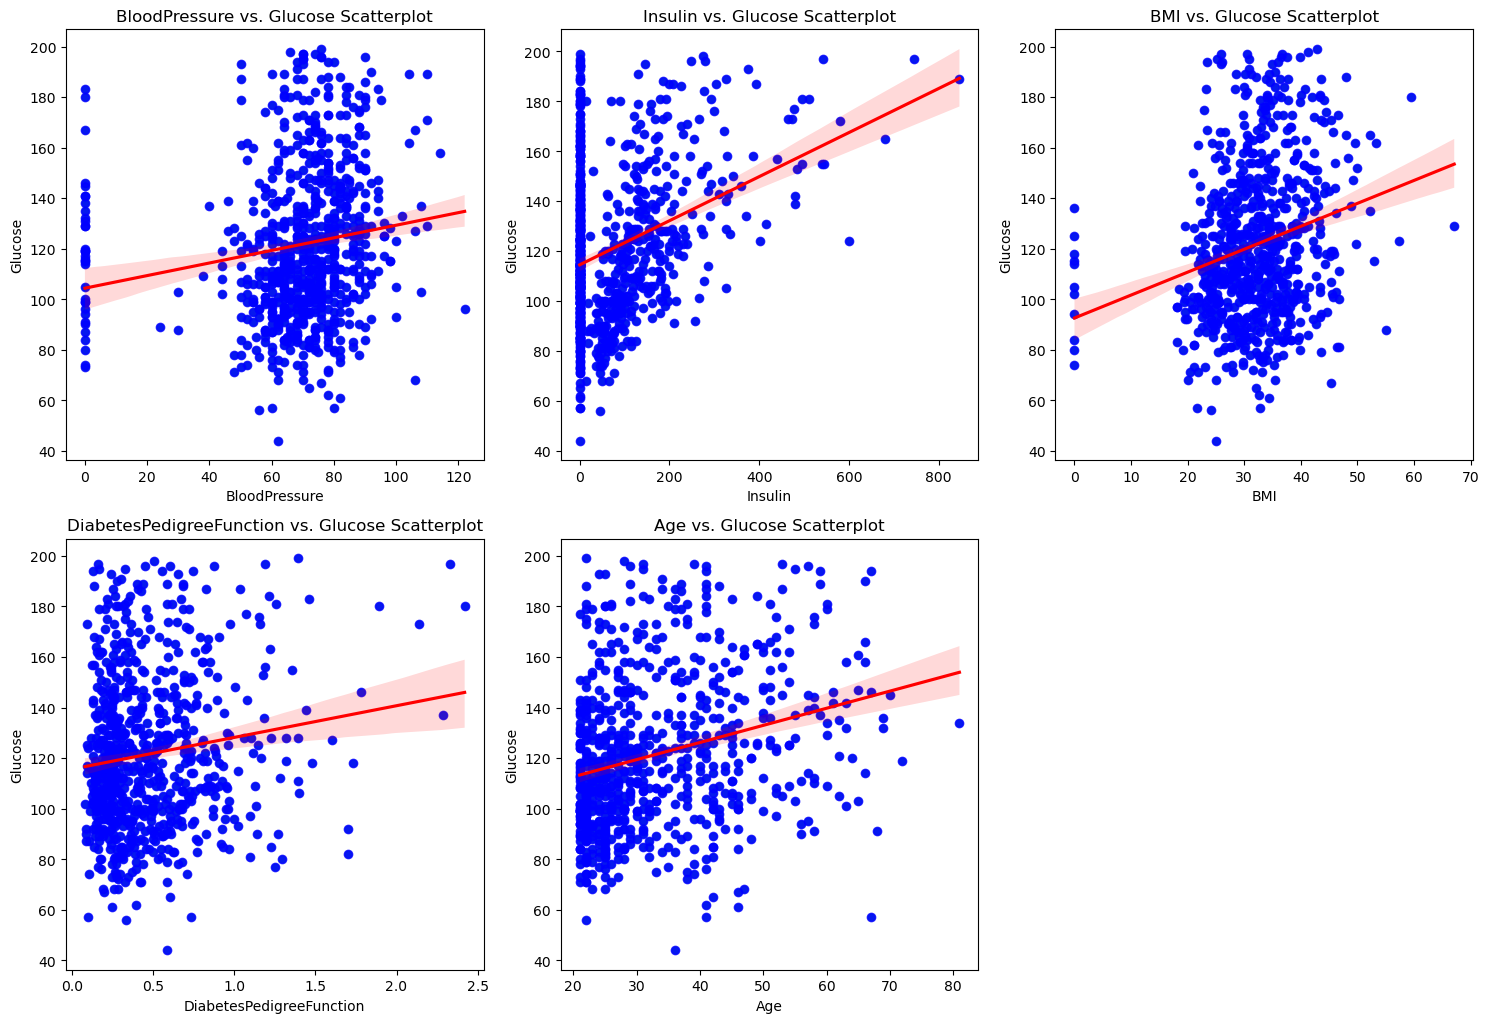

In [192]:
non_glucose_cols = df.columns.tolist()[1:df.shape[1] - 1]

plt.figure(figsize=(15, 15))

# create each scatterplot
for i, col in enumerate(non_glucose_cols):
    plt.subplot(3, 3, i+1)
    plt.title(f"{col} vs. Glucose Scatterplot")
    sns.scatterplot(data=df_nonzero, x=col, y="Glucose")
    sns.regplot(data=df_nonzero, x=col, y="Glucose", color="red", scatter_kws={"color": "blue"})
    plt.xlabel(f"{col}")
    plt.ylabel("Glucose")

plt.tight_layout()
plt.show()

#### Fitting the Model

In [193]:
# add constant term to multiple linear regression model
X = sm.add_constant(df_nonzero[non_glucose_cols])
y = df_nonzero['Glucose']

# fit multiple linear regression model
glucose_imp_model = sm.OLS(y, X).fit()
glucose_imp_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Glucose   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     41.92
Date:                Wed, 08 May 2024   Prob (F-statistic):           3.81e-38
Time:                        13:44:56   Log-Likelihood:                -3590.1
No. Observations:                 762   AIC:                             7192.
Df Residuals:                     756   BIC:                             7220.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       68.9714      5.286     13.048      0.000      58.595      79.348
BloodPressure                0.0380      0.054      0.702      0.483      -0.068       0.144
Insulin                      0.0802      0.009      9.118      0.000       0.063       0.097
BMI                          0.5876      0.132      4.445      0.000       0.328       0.847
DiabetesPedigreeFunction     4.6285      3.019      1.533      0.126      -1.299      10.556
Age                          0.6789      0.086      7.872      0.000       0.510       0.848
==============================================================================
Omnibus:                       27.201   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.170
Skew:                           0.470   Prob(JB):                     4.63e-07
Kurtosis:                       3.184   Cond. No.                         821.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Check for Constant Variance and Uncorrelated Errors

The scatterplot of the fitted values against the residuals show that the residuals randomly scatter around the zero line. Hence, the constant variance and uncorrelated errors assumptions hold.

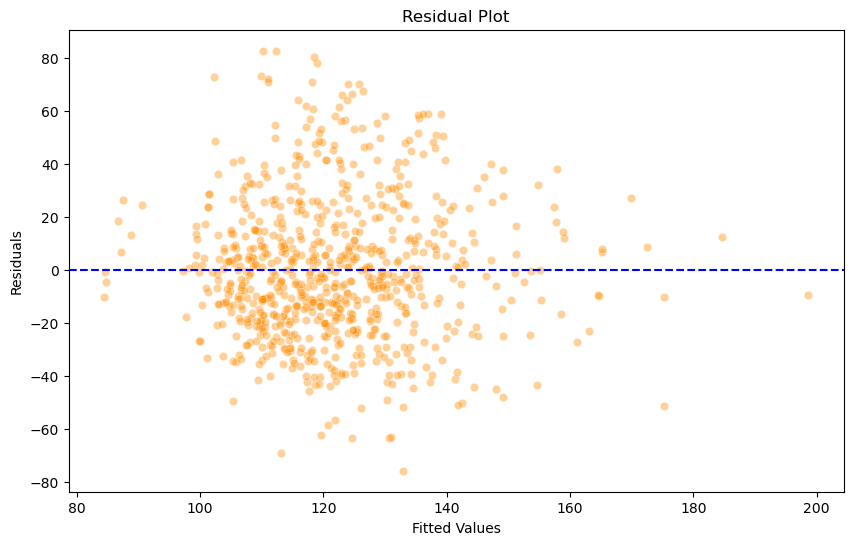

In [194]:
# create residual plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=glucose_imp_model.fittedvalues, y=glucose_imp_model.resid, alpha=0.4, color='darkorange')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')

# add horizontal line at y = 0
plt.axhline(y=0, color='blue', linestyle='--')

plt.show()

#### Check for Normality

The histogram and Q-Q Plot of the residuals show that the distribution of residuals is symmetrical but with slightly heavy tails. We conclude the normality assumption approximately holds.

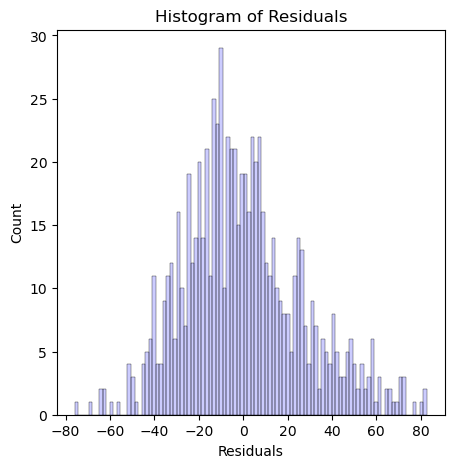

<Figure size 500x500 with 0 Axes>

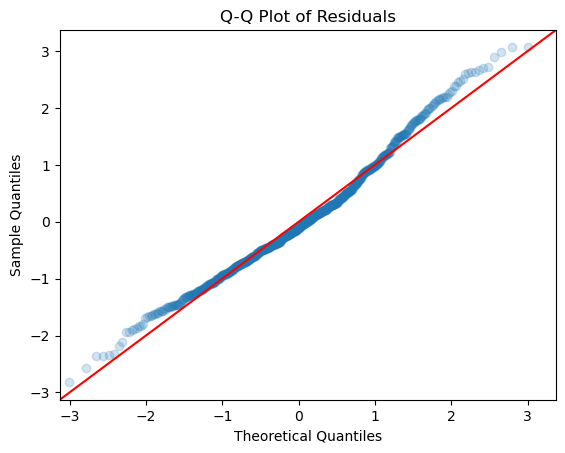

In [195]:
# Create a histogram of residuals
plt.figure(figsize=(5, 5))
sns.histplot(glucose_imp_model.resid, bins=100, kde=False,color='blue', alpha=0.2)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Count')

# Create a Q-Q plot of residuals
plt.figure(figsize=(5, 5))
QQ = ProbPlot(glucose_imp_model.resid, dist=stats.norm, fit=True)
QQ.qqplot(line='45', alpha=0.2, color='orange')
plt.title('Q-Q Plot of Residuals')

plt.show()

#### Imputing Missing Glucose Values

In [196]:
new_points = []
missing_glucose_inds = list(df[df['Glucose'] == 0].index)

for ind in missing_glucose_inds:
    new_points.append({key:val[ind] for key, val in df[df['Glucose'] == 0][non_glucose_cols].to_dict().items()})

new_pts = []

for pt in new_points:
    pt['Const'] = 1.0
    # move constant to beginning of each dictionary
    moved_pair = {'Const': pt['Const']}
    remaining = {key: value for key, value in pt.items() if key != 'Const'}
    
    # Concatenate the dictionaries to form the final reordered dictionary
    new_pts.append({**moved_pair, **remaining})

In [197]:
glucose_imp_vals = [glucose_imp_model.get_prediction(pd.DataFrame(pt, index=[0])).predicted_mean[0] for pt in new_pts]
print(f"Predictions:\n{glucose_imp_vals}\n")


Predictions:
[100.89472143560516, 105.54765844088693, 107.09754254313805, 122.82676333251301, 125.6740795545843]



In [198]:
for i, val in enumerate(glucose_imp_vals):
    df.loc[missing_glucose_inds[i], 'Glucose'] = int(val)

In [199]:
df.loc[missing_glucose_inds, 'Glucose']

75     100
182    105
342    107
349    122
502    125
Name: Glucose, dtype: int64

## Which Classification Model Best Predicts Whether a Patient Has Diabetes?

The cross-validated accuracy scores of each of the classification models of the data created below will be compared to see which classification model is best for predicting whether a patient has diabetes.

First, the data must be scaled (the support vector machine and logistic regression models will be inaccurate if not scaled). Then I will perform a 80/20 split of the data: 80% of the data is used for the 5-fold cross validation of each of the models, and the remaining 20% of the data will be used to test the accuracy of the model that performs best on the training data.

Upon 10-fold cross validation, the rankings of the performance of the classification models are as follows:

1. XGBoost (Accuracy: 76.360%)

2. Support Vector Machine (Accuracy: 76.198%)

3. Random Forest (Accuracy: 75.855%)

4. Logistic Regression (Accuracy: 75.711%)


Therefore, the k-Nearest Neighbor model was chosen as the best classification model to determine whether a patient has diabetes.

In [200]:
np.random.seed(1) # for reproducible results

# 80/20 train-test split of the scaled data
x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled = train_test_split(scale(df.drop('Outcome', axis=1)), df['Outcome'], test_size=0.2)

cv = KFold(n_splits=10, shuffle=True)

## Support Vector Machine for Classification

In [201]:
np.random.seed(1) # for reproducible results

svm_params = {'C': [10**i for i in range(-2, 3)], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma': ['scale', 'auto']}

svm_grid_search = GridSearchCV(svm.SVC(), svm_params, cv=cv)
svm_grid_search.fit(x_train_scaled, y_train_scaled)

print(svm_grid_search.best_params_)

{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}


In [202]:
np.random.seed(1) # for reproducible results

svm_model = svm.SVC(**svm_grid_search.best_params_).fit(x_train_scaled, y_train_scaled)
svm_cv = cross_validate(svm_model, x_train_scaled, y_train_scaled, cv=cv)

print(f"10-fold cross-validation yields an accuracy of {np.mean(svm_cv['test_score'])} for the SVM model.")

10-fold cross-validation yields an accuracy of 0.7701216287678477 for the SVM model.


## Logistic Regression for Classification

In [203]:
np.random.seed(1) # for reproducible results

lreg_params = {'penalty': ['l1', 'l2', 'elasticnet', None], 'C': [10**i for i in range(-6, -1)], 'fit_intercept': [True, False],
              'solver': ['sag', 'saga', 'newton-cholesky', 'liblinear'], 'max_iter': [10**i for i in range(1, 3)]}

warnings.filterwarnings('ignore')

lreg_grid_search = GridSearchCV(LogisticRegression(), lreg_params, cv=cv)
lreg_grid_search.fit(x_train_scaled, y_train_scaled)

print(lreg_grid_search.best_params_)

{'C': 0.0001, 'fit_intercept': True, 'max_iter': 10, 'penalty': None, 'solver': 'sag'}


In [204]:
np.random.seed(1) # for reproducible results

lreg_model = LogisticRegression(**lreg_grid_search.best_params_).fit(x_train_scaled, y_train_scaled)
lreg_cv = cross_validate(lreg_model, x_train_scaled, y_train_scaled, cv=cv)

print(f"10-fold cross-validation yields an accuracy of {np.mean(lreg_cv['test_score'])} for the Logistic Regression model.")

10-fold cross-validation yields an accuracy of 0.773320994182972 for the Logistic Regression model.


## Random Forest for Classification

In [205]:
np.random.seed(1) # for reproducible results

rforest_params = {'n_estimators': [50*i for i in range(1, 7)], 'max_features': ['sqrt', 'log2', None], 
                  'class_weight': ['balanced', 'balanced_subsample']}

rforest_grid_search = GridSearchCV(RandomForestClassifier(), rforest_params, cv=cv)
rforest_grid_search.fit(x_train_scaled, y_train_scaled)

print(rforest_grid_search.best_params_)

{'class_weight': 'balanced', 'max_features': 'log2', 'n_estimators': 200}


In [206]:
np.random.seed(1) # for reproducible results

rforest_model = RandomForestClassifier(**rforest_grid_search.best_params_).fit(x_train_scaled, y_train_scaled)
rforest_cv = cross_validate(rforest_model, x_train_scaled, y_train_scaled, cv=cv)

print(f"10-fold cross-validation yields an accuracy of {np.mean(rforest_cv['test_score'])} for the Random Forest model.")

10-fold cross-validation yields an accuracy of 0.7471443680592279 for the Random Forest model.


## XGBoost for Classification

In [207]:
np.random.seed(1) # for reproducible results

xgb_params = {'n_estimators': [50*i for i in range(1, 7)], 'booster': ['gbtree', 'gblinear', 'dart'], 
              'tree_method': ['approx', 'hist'], 'sampling_method': ['uniform', 'gradient_based']}

xgb_grid_search = GridSearchCV(XGBClassifier(), xgb_params, cv=cv)
xgb_grid_search.fit(x_train_scaled, y_train_scaled)

print(xgb_grid_search.best_params_)

{'booster': 'gblinear', 'n_estimators': 50, 'sampling_method': 'uniform', 'tree_method': 'approx'}


In [208]:
np.random.seed(1) # for reproducible results

xgb_model = XGBClassifier(**xgb_grid_search.best_params_).fit(x_train_scaled, y_train_scaled)
xgb_cv = cross_validate(xgb_model, x_train_scaled, y_train_scaled, cv=cv)

print(f"10-fold cross-validation yields an accuracy of {np.mean(xgb_cv['test_score'])} for the XGBoost model.")

10-fold cross-validation yields an accuracy of 0.7699629825489158 for the XGBoost model.


## Logistic Regression Model Performance on the Test Data

The Logistic Regression model performed even better on the test data with an accuracy of 79.870%, which makes it clear that the Logistic Regression model is fit quite well. Further analysis of the model is below.

In [214]:
np.random.seed(1) # for reproducible results

lreg_test_predictions = lreg_model.predict(x_test_scaled)
lreg_test_accuracy = np.sum(lreg_test_predictions == y_test_scaled)/len(y_test_scaled)
print(f"On the test data, the Logistic Regression model yields an accuracy of {round(lreg_test_accuracy, 5)}.")

On the test data, the Logistic Regression model yields an accuracy of 0.7987.


## Model Evaluation

Below is a confusion matrix of the results of the Logistic Regression model. A confusion matrix takes the form

$$\begin{pmatrix}
(\text{True Positives}) & (\text{False Negatives})\\
(\text{False Positives}) & (\text{True Negatives})
\end{pmatrix}.$$

The following is an analysis of the Logistic Regression model based on the confusion matrix:

- The Logistic Regression model's **precision** is 76.19%; if the model predicts that a patient has not been diagnosed with diabetes, there is an 76.19% chance that the patient truly has not been diagnosed.

- The Logistic Regression model's **sensitivity** is 60.377%; if a patient has not been diagnosed with diabetes, there is a 60.377% chance that the model predicts that the patient has not been diagnosed.

- The Logistic Regression model's **specificity** is 90.099%; if a patient has been diagnosed with diabetes, there is a 90.099% chance that the model predicts that the patient has been diagnosed.

- The Logistic Regression model's **area under the ROC curve (AUC)** is 87%; there is an 87% chance that the model will classify a randomly chosen diabetic as a diabetic across various probability threshold values (if the probability of a patient being diabetic is over a certain threshold, the patient is classified as a diabetic). Overall, this indicates the Logistic Regression model effectively predicts whether a patient has been diagnosed with diabetes.


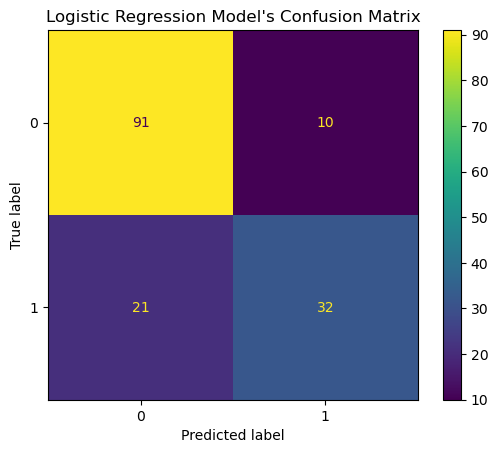

In [215]:
c_matrix = confusion_matrix(y_test_scaled, lreg_test_predictions, labels=lreg_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=c_matrix, display_labels=lreg_model.classes_)

disp.plot()
disp.ax_.set(title="Logistic Regression Model's Confusion Matrix")

plt.show()

In [219]:
true_negatives = c_matrix[0,0]
false_negatives = c_matrix[1,0]
false_positives = c_matrix[0,1]
true_positives = c_matrix[1,1]


In [225]:
# precision, sensitivity, specificity functions
def model_precision(tp, fp):
    return tp/(tp+fp)

def model_sensitivity(tp, fn):
    return tp/(tp+fn)

def model_specificity(tn, fp):
    return tn/(tn+fp)


In [228]:
print(f"The Logistic Regression model's precision is {model_precision(true_positives, false_positives)}.")
print(f"The Logistic Regression model's sensitivity is {model_sensitivity(true_positives, false_negatives)}.") 
print(f"The Logistic Regression model's specificity is {model_specificity(true_negatives, false_positives)}.")

The Logistic Regression model's precision is 0.7619047619047619.
The Logistic Regression model's sensitivity is 0.6037735849056604.
The Logistic Regression model's specificity is 0.900990099009901.


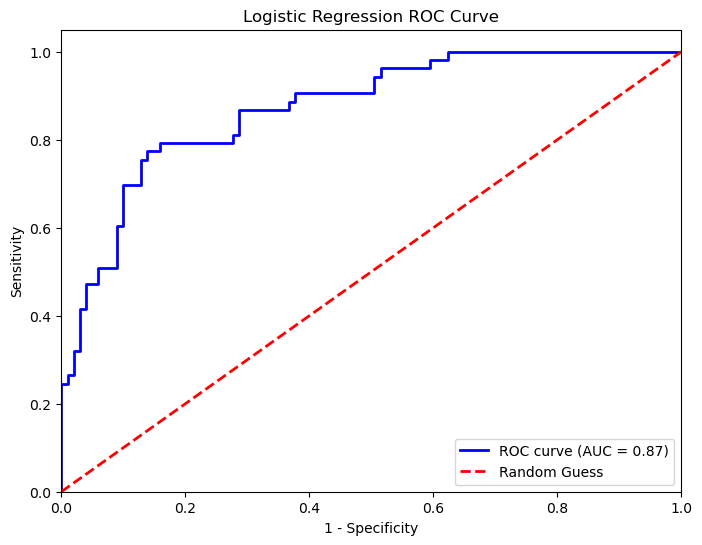

In [227]:
# predict probabilities for the test set
y_probs = lreg_model.predict_proba(x_test_scaled)[:, 1]

# compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test_scaled, y_probs)
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='r', linestyle='--', lw=2, label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.title('Logistic Regression ROC Curve')
plt.legend(loc='lower right')
plt.show()

## Conclusions

Upon analysis of the diabetes.csv data set, I was able to answer the following questions:

1. Is a patient's glucose data enough to classify them as a diagnosed diabetic? The answer is no because glucose is not directly correlated with whether a patient has diabetes (i.e., they have excellent control of their blood sugar through medication or lifestyle changes).

2. If more predictors than just glucose levels are required, are there any that are unnecessary for classification? The predictors SkinThickness and Insulin (surprisingly) were not very correlated to whether a patient has diabetes. This is likely due to some missing data for these two predictors in particular.

3. Which type of classification model best predicts whether a patient has diabetes? The linear support vector machine model performed best, with the logistic regression model being a close second.


Beyond the questions I have asked, I found some other statistics of my logistic regression model using a confusion matrix. The confusion matrix was used to calculate my model's precision, specificity, sensitivity, and AUC. According to the evaluation metrics, the logistic regression model has predictive power of whether a person has been diagnosed with diabetes. I also found some other interesting correlations after analyzing the data set. For example, age and blood pressure are almost as correlated to each other as glucose and a diabetes diagnosis are.

This project could be a good start to automating diabetes diagnoses. In fact, it may be easier to create such a model because any instance of a hemoglobin A1C being within the diabetic range signals diabetes.